# Compile Catalogs

In [1]:
#from astroquery.gaia import Gaia
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io import fits
from astropy.table import Table
import numpy as np
from astropy.io.ascii import read
import glob
import os

## Import Catalogs

In [2]:
# Open the GCNS catalog
# https://arxiv.org/abs/2012.02061
# Parse using the ReadMe:
gcns = read('/datax/scratch/emmay/GCNS/table1c.dat', format='cds', readme='/datax/scratch/emmay/GCNS/ReadMe')
gcns.columns

<TableColumns names=('GaiaEDR3','RAdeg','e_RAdeg','DEdeg','e_DEdeg','Plx','e_Plx','pmRA','e_pmRA','pmDE','e_pmDE','Gmag','RFG','BPmag','RFBP','RPmag','RFRP','E(BP/RP)','RUWE','IPDfmp','RV','e_RV','r_RV','f_RV','GCNSprob','WDprob','Dist1','Dist16','Dist50','Dist84','xcoord50','xcoord16','xcoord84','ycoord50','ycoord16','ycoord84','zcoord50','zcoord16','zcoord84','Uvel50','Uvel16','Uvel84','Vvel50','Vvel16','Vvel84','Wvel50','Wvel16','Wvel84','GUNN','r_GUNN','gmag','e_gmag','rmag','e_rmag','imag','e_imag','zmag','e_zmag','2MASS','Jmag','e_Jmag','Hmag','e_Hmag','Ksmag','e_Ksmag','WISE','W1mag','e_W1mag','W2mag','e_W2mag','W3mag','e_W3mag','W4mag','e_W4mag')>

In [3]:
# Open the Gaia-ESO file
# https://doi.eso.org/10.18727/archive/25
hdulist = fits.open('/datax/scratch/emmay/GaiaESO/result_ervvfchjzcb7sbg9.fits')
catalog_hdu = hdulist[1]
GaiaESO = catalog_hdu.data

In [4]:
# Open the NEID file
# https://neid.ipac.caltech.edu/search_advanced.php
neid = Table.read('/datax/scratch/emmay/NEID/table_Level-2.csv')
# Clean mask on full NEID table
mask = (
    (neid['qra'] != None) & (neid['qdec'] != None) &
    (neid['qra'] != '') & (neid['qdec'] != '') &
    (neid['qra'] != 'None') & (neid['qdec'] != 'None')
)

# Apply mask ONCE to get clean NEID
neid_clean = neid[mask]
len(neid_clean)

14205

In [5]:
# Open the HIRES file
# https://koa.ipac.caltech.edu/UserGuide/public_data.html
hires = Table.read('/datax/scratch/emmay/HIRES/hires.csv')
mask = np.isfinite(hires['ra']) & np.isfinite(hires['dec'])
mask &= (~hires['ra'].mask) & (~hires['dec'].mask)
mask &= hires['dec'] <=90
hires_clean = hires[mask]

In [6]:
# Open the KPF file
# https://koa.ipac.caltech.edu/UserGuide/public_data.html
kpf = Table.read('/datax/scratch/emmay/KPF/kpf.csv')
mask = np.isfinite(kpf['ra']) & np.isfinite(kpf['dec'])
mask &= (~kpf['ra'].mask) & (~kpf['dec'].mask)
mask &= kpf['dec'] <=90
kpf_clean = kpf[mask]
kpf_clean

koaid,ofname,instrument,currinst,object,targname,koaimtyp,frameno,ra,dec,date_obs,ut,elaptime,waveblue,wavered,red,green,ca_hk,semid,proginst,progpi,progtitl,fileurl,filehand
str25,str25,str3,str7,str68,str18,str9,int64,float64,float64,str10,str11,float64,int64,int64,str3,str3,str3,str10,str9,str11,str139,str127,str49
KP.20220910.30773.92.fits,KP.20220910.30773.92.fits,KPF,--,--,87318378,undefined,312,313.24067,-12.71619,2022-09-10,08:32:53.93,0.0,3900,4450,NO,NO,YES,2022B_ENG,KECK,kpfeng,KPF Engineering,https://koa.ipac.caltech.edu/cgi-bin/getKOA/nph-getKOA?instrument=KP&filehand=/KPF/2022/20220910/lev0/KP.20220910.30773.92.fits,/KPF/2022/20220910/lev0/KP.20220910.30773.92.fits
KP.20220910.30820.87.fits,KP.20220910.30820.87.fits,KPF,--,--,87318378,undefined,313,313.24067,-12.71619,2022-09-10,08:33:40.85,0.0,3900,4450,NO,NO,YES,2022B_ENG,KECK,kpfeng,KPF Engineering,https://koa.ipac.caltech.edu/cgi-bin/getKOA/nph-getKOA?instrument=KP&filehand=/KPF/2022/20220910/lev0/KP.20220910.30820.87.fits,/KPF/2022/20220910/lev0/KP.20220910.30820.87.fits
KP.20220910.30852.09.fits,KP.20220910.30852.09.fits,KPF,--,--,87318378,undefined,314,313.24067,-12.71619,2022-09-10,08:34:11.96,0.0,3900,4450,NO,NO,YES,2022B_ENG,KECK,kpfeng,KPF Engineering,https://koa.ipac.caltech.edu/cgi-bin/getKOA/nph-getKOA?instrument=KP&filehand=/KPF/2022/20220910/lev0/KP.20220910.30852.09.fits,/KPF/2022/20220910/lev0/KP.20220910.30852.09.fits
KP.20220910.30899.67.fits,KP.20220910.30899.67.fits,KPF,--,--,87318378,undefined,315,313.24067,-12.71619,2022-09-10,08:34:59.39,0.0,3900,4450,NO,NO,YES,2022B_ENG,KECK,kpfeng,KPF Engineering,https://koa.ipac.caltech.edu/cgi-bin/getKOA/nph-getKOA?instrument=KP&filehand=/KPF/2022/20220910/lev0/KP.20220910.30899.67.fits,/KPF/2022/20220910/lev0/KP.20220910.30899.67.fits
KP.20220910.30947.12.fits,KP.20220910.30947.12.fits,KPF,--,--,87318378,undefined,316,313.24067,-12.71619,2022-09-10,08:35:46.82,0.0,3900,4450,NO,NO,YES,2022B_ENG,KECK,kpfeng,KPF Engineering,https://koa.ipac.caltech.edu/cgi-bin/getKOA/nph-getKOA?instrument=KP&filehand=/KPF/2022/20220910/lev0/KP.20220910.30947.12.fits,/KPF/2022/20220910/lev0/KP.20220910.30947.12.fits
KP.20220910.30988.11.fits,KP.20220910.30988.11.fits,KPF,--,--,87318378,undefined,317,313.24067,-12.71619,2022-09-10,08:36:17.93,10.0,3900,4450,NO,NO,YES,2022B_ENG,KECK,kpfeng,KPF Engineering,https://koa.ipac.caltech.edu/cgi-bin/getKOA/nph-getKOA?instrument=KP&filehand=/KPF/2022/20220910/lev0/KP.20220910.30988.11.fits,/KPF/2022/20220910/lev0/KP.20220910.30988.11.fits
KP.20220910.31190.54.fits,KP.20220910.31190.54.fits,KPF,--,--,118360893,undefined,318,255.63317,12.54731,2022-09-10,08:39:50.60,0.0,3900,4450,NO,NO,YES,2022B_ENG,KECK,kpfeng,KPF Engineering,https://koa.ipac.caltech.edu/cgi-bin/getKOA/nph-getKOA?instrument=KP&filehand=/KPF/2022/20220910/lev0/KP.20220910.31190.54.fits,/KPF/2022/20220910/lev0/KP.20220910.31190.54.fits
KP.20220910.31330.66.fits,KP.20220910.31330.66.fits,KPF,--,--,118548263,undefined,319,255.67329,12.69375,2022-09-10,08:42:10.34,0.0,3900,4450,NO,NO,YES,2022B_ENG,KECK,kpfeng,KPF Engineering,https://koa.ipac.caltech.edu/cgi-bin/getKOA/nph-getKOA?instrument=KP&filehand=/KPF/2022/20220910/lev0/KP.20220910.31330.66.fits,/KPF/2022/20220910/lev0/KP.20220910.31330.66.fits
KP.20220910.31441.42.fits,KP.20220910.31441.42.fits,KPF,--,--,118360893,undefined,320,255.63604,12.54731,2022-09-10,08:44:01.01,0.0,3900,4450,NO,NO,YES,2022B_ENG,KECK,kpfeng,KPF Engineering,https://koa.ipac.caltech.edu/cgi-bin/getKOA/nph-getKOA?instrument=KP&filehand=/KPF/2022/20220910/lev0/KP.20220910.31441.42.fits,/KPF/2022/20220910/lev0/KP.20220910.31441.42.fits


In [7]:
# Open HARPS
with fits.open('/datax/scratch/emmay/HARPS/J_A+A_636_A74_list.dat.fits') as hdul:
    data = hdul[1].data

# Convert to Pandas for easy cleaning
df = pd.DataFrame(data.tolist(), columns=data.columns.names)

for col in ['RAh', 'RAm', 'RAs', 'DE-', 'DEd', 'DEm', 'DEs']:
    # Decode bytes -> string -> strip -> safe for numeric
    df[col] = df[col].apply(lambda x: x.decode('utf-8').strip())

# Now convert numeric parts to float
df['RAh'] = df['RAh'].astype(float)
df['RAm'] = df['RAm'].astype(float)
df['RAs'] = df['RAs'].astype(float)

df['DEd'] = df['DEd'].astype(float)
df['DEm'] = df['DEm'].astype(float)
df['DEs'] = df['DEs'].astype(float)

# DE- stays string
df['DE-'] = df['DE-'].astype(str).str.strip()

# Compute RA in decimal degrees
df['RA_deg'] = (df['RAh'] + df['RAm']/60 + df['RAs']/3600) * 15

# Compute Dec with sign
sign = np.where(df['DE-'] == '-', -1, 1)
df['Dec_deg'] = sign * (df['DEd'] + df['DEm']/60 + df['DEs']/3600)

harps = Table.from_pandas(df)


In [8]:
# Open APOGEE
# https://www.sdss4.org/dr17/irspec/spectro_data/
hdulist = fits.open('/datax/scratch/emmay/APOGEE/allStarLite-dr17-synspec_rev1.fits')
catalog_hdu = hdulist[1]
apogee = catalog_hdu.data
mask = ~np.isnan(apogee['RA']) & ~np.isnan(apogee['DEC'])
apogee = apogee[mask]
type(apogee)

astropy.io.fits.fitsrec.FITS_rec

In [9]:
# Open CARMENES
df = pd.read_csv(
    "/datax/scratch/emmay/CARMENES/carmenes_withcoords.csv",
    skiprows=6,
    engine='python'  # Better for messy quoting and multiline fields
)
print(df.columns.tolist())
# Clean up column names
df.columns = df.columns.str.strip()

# Drop empty/filler rows
df = df[df['Target'].notna() & df['J2000 Position'].notna()]

# Extract RA and DEC from 'J2000 Position'
df[['RA', 'DEC']] = df['J2000 Position'].str.extract(r'([0-9:.]+)\s+([+\-0-9:.]+)')

# Keep only needed columns
CARMENES = df[['Target', 'RA', 'DEC']].drop_duplicates()
CARMENES.columns

['Target', 'OType', 'J2000 Position', 'Refs', 'Resolver']


Index(['Target', 'RA', 'DEC'], dtype='object')

In [10]:
# Open GALAH
# https://www.galah-survey.org/
galah = Table.read("/datax/scratch/emmay/GALAH/galah_dr4_vac_wise_tmass_gaiadr3_240705.fits", hdu=1)
# Convert Astropy table to Pandas
galah_df = galah.to_pandas()

# Drop rows where any of the specified columns are NaN
galah_df_clean = galah_df.dropna(subset=['raj2000', 'dej2000', 'sobject_id'])
galah_clean = Table.from_pandas(galah_df_clean)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'solution_id' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'source_id' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'random_index' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'astrometric_n_obs_al' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'astrometric_n_obs_ac' from integer to float
  exec(code_obj

In [62]:
# Open HST data
# https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html
# === Set the directory and file pattern ===
csv_dir = '/datax/scratch/emmay/HST'
pattern = os.path.join(csv_dir, 'MAST_Crossmatch_HSCv3_MagApe_part*.csv')
csv_files = sorted(glob.glob(pattern))

# === Load all files, skipping the first 4 rows ===
df_list = [pd.read_csv(f, skiprows=4) for f in csv_files]

# === Combine into one big DataFrame ===
HST = pd.concat(df_list, ignore_index=True)
HST = HST.drop_duplicates(subset=['RA', 'DEC'], keep='first')


# Load the files with spectra
HST_spec_file = '/datax/scratch/emmay/HST/HSC_Spectra.csv'
HST_spec = pd.read_csv(HST_spec_file, skiprows=4)



In [63]:
HST_spec

,ObjID,DatasetName,MatchID,RA,Dec,TargetName,HSCMatch
0,20010,HAG_J072655.67+691648.9_J8HPAXAEQ_V01.SPEC1D,19657846,111.732010,69.280257,HAG_J072655.67+691648.9_J8HPAXAEQ,Y
1,20011,HAG_J072655.69+691648.9_J8HPAOZMQ_V01.SPEC1D,19657846,111.732010,69.280257,HAG_J072655.69+691648.9_J8HPAOZMQ,Y
2,20012,HAG_J072655.76+691729.7_J8HPAOZMQ_V01.SPEC1D,19659745,111.732295,69.291592,HAG_J072655.76+691729.7_J8HPAOZMQ,Y
3,20013,HAG_J072655.82+691620.0_J8HPAOZMQ_V01.SPEC1D,19659417,111.732537,69.272240,HAG_J072655.82+691620.0_J8HPAOZMQ,Y
4,20014,HAG_J072656.34+691704.7_J8HPAXAEQ_V01.SPEC1D,19660230,111.734782,69.284648,HAG_J072656.34+691704.7_J8HPAXAEQ,Y
...,...,...,...,...,...,...,...
45757,20005,HAG_J072655.41+691553.1_J8HPAOZMQ_V01.SPEC1D,19658837,111.730856,69.264767,HAG_J072655.41+691553.1_J8HPAOZMQ,Y
45758,20006,HAG_J072655.42+691616.9_J8HPAXAEQ_V01.SPEC1D,19656051,111.730975,69.271386,HAG_J072655.42+691616.9_J8HPAXAEQ,Y
45759,20007,HAG_J072655.44+691616.9_J8HPAOZMQ_V01.SPEC1D,19656051,111.730975,69.271386,HAG_J072655.44+691616.9_J8HPAOZMQ,Y
45760,20008,HAG_J072655.48+691802.2_J8HPAOZMQ_V01.SPEC1D,19656065,111.731114,69.300624,HAG_J072655.48+691802.2_J8HPAOZMQ,Y


In [64]:
# Match HSC coords to those with spectra
# Step 1: Build SkyCoord objects from RA/DEC in degrees
hst_coords = SkyCoord(ra=HST['RA'] * u.deg, dec=HST['DEC'] * u.deg)

# Force RA and Dec to numeric, coercing any weird values to NaN
#HST_spec['RA'] = pd.to_numeric(HST_spec['RA'], errors='coerce')
#HST_spec['Dec'] = pd.to_numeric(HST_spec['Dec'], errors='coerce')

# Drop rows with any NaNs in RA or DEC
HST_spec_clean = HST_spec.dropna(subset=['RA', 'Dec']).copy()

# Just to be sure, check again that the types are correct
#assert HST_spec_clean['RA'].dtype == 'float64'
#assert HST_spec_clean['Dec'].dtype == 'float64'

# Build SkyCoord — using .values ensures NumPy float array (not object)
hst_spec_coords = SkyCoord(ra=HST_spec_clean['RA'].values * u.deg,
                           dec=HST_spec_clean['Dec'].values * u.deg)

# Step 2: Cross-match HST to HST_spec
idx, d2d, _ = hst_coords.match_to_catalog_sky(hst_spec_coords)

# Step 3: Apply a 2 arcsec threshold
max_sep = 2 * u.arcsec
matched = d2d < max_sep


HST['is_in_HST_spec'] = matched.astype(int)
# Step 4: Add match info to HST, filter to only those with matches
HST_matched = HST[HST['is_in_HST_spec'] ==1 ]
HST_matched['GaiaEDR3'] = HST_matched['GaiaEDR3'].astype(int)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [65]:
HST_matched

,RA,DEC,GaiaEDR3,MatchID,distanceArcMin,MatchRA,MatchDec,DSigma,AbsCorr,NumFilters,...,W3_F128N,W3_F128N_MAD,W3_F128N_N,W3_F132N,W3_F132N_MAD,W3_F132N_N,W3_F167N,W3_F167N_MAD,W3_F167N_N,is_in_HST_spec
283,76.377669,52.830673,266077145295628000,55623969,0.003459,76.377654,52.830730,0.0,Y,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
300,82.187365,-65.447962,4660766641264339968,76681759,0.018743,82.187102,-65.448254,0.0,Y,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
307,86.821235,-51.066136,4792774797545799680,17100378,0.005926,86.821109,-51.066077,0.0,Y,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
439,170.521590,-24.777767,3534414590303810048,24583184,0.020209,170.521960,-24.777785,0.0,N,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
441,170.521605,-24.777618,3534414594600350208,24583184,0.021765,170.521960,-24.777785,0.0,N,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
546,204.705028,70.285347,1686708050268590080,105254736,0.012332,204.704842,70.285151,0.0,Y,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


# Espresso Tough (NOT WORKING YET)

In [18]:
'''
# Open ESPRESSO
# 
# Load from local HTML file
tables = pd.read_html("/datax/scratch/emmay/ESPRESSO/query.html")

# Check how many tables were found
print(f"{len(tables)} tables found.")

# Keep only tables with at least 3 rows
data_tables = [t for t in tables if len(t) >= 3]

print(f"Found {len(data_tables)} tables with ≥ 3 rows.")
merged_df = pd.concat(data_tables, ignore_index=True)
'''


'\n# Open ESPRESSO\n# \n# Load from local HTML file\ntables = pd.read_html("/datax/scratch/emmay/ESPRESSO/query.html")\n\n# Check how many tables were found\nprint(f"{len(tables)} tables found.")\n\n# Keep only tables with at least 3 rows\ndata_tables = [t for t in tables if len(t) >= 3]\n\nprint(f"Found {len(data_tables)} tables with ≥ 3 rows.")\nmerged_df = pd.concat(data_tables, ignore_index=True)\n'

## Some Sanity Checks
Comparing with https://github.com/jradavenport/spectro100/blob/main/gathering%20data.ipynb

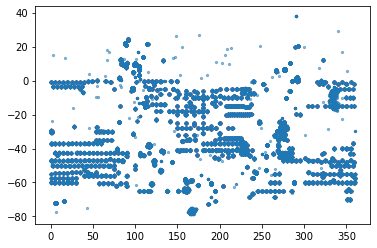

In [19]:
# Sanity check of RA vs DEC plot compared to Jim's
plt.figure()
plt.scatter(GaiaESO['RA'], GaiaESO['DECLINATION'], s=5, alpha=0.5)

In [20]:
GCNS_C = SkyCoord(ra=gcns['RAdeg'], dec=gcns['DEdeg'], frame='icrs')
GaiaESO_C = SkyCoord(ra=GaiaESO['RA']*u.degree, dec=GaiaESO['DECLINATION']*u.degree)


In [21]:
# Again, good sanity check - matches with what Jim got
Gdx = GCNS_C.match_to_catalog_sky(GaiaESO_C)
Gmtch = Gdx[0][Gdx[1].to('arcsec').value < 5]
print(sum(Gdx[1].to('arcsec').value < 5))

147


## Crossmatching with GCNS

In [22]:
# 1) Use match_to_catalog_sky 
idx, d2d, _ = GCNS_C.match_to_catalog_sky(GaiaESO_C)

# 2) Limit to matches within 2 arcsec
matches = d2d < 2 * u.arcsec

# 3) Prepare arrays
is_in_GaiaESO = np.zeros(len(gcns), dtype=int)
GaiaESO_name = np.full(len(gcns), np.nan, dtype=object)

# 4) Fill only for matched rows
is_in_GaiaESO[matches] = 1
GaiaESO_name[matches] = GaiaESO['OBJECT'][idx[matches]]

# 5) Store in new copy
catalog_summary = gcns["GaiaEDR3", "RAdeg", "DEdeg", "Dist50", "Gmag", "BPmag", "RPmag"].copy()
catalog_summary['is_in_GaiaESO'] = is_in_GaiaESO
catalog_summary['GaiaESO_name'] = GaiaESO_name
catalog_summary.rename_column('GaiaEDR3', 'GCNS_name')
catalog_summary.rename_column('RAdeg', 'GCNS_RA')
catalog_summary.rename_column('DEdeg', 'GCNS_DEC')


In [23]:
catalog_summary[catalog_summary['is_in_GaiaESO']==1]

GCNS_name,GCNS_RA,GCNS_DEC,Dist50,Gmag,BPmag,RPmag,is_in_GaiaESO,GaiaESO_name
,deg,deg,kpc,mag,mag,mag,,
int64,float64,float64,float64,float64,float64,float64,int64,object
2336728947968831104,1.8871494,-23.8183163,0.0328,8.4831,8.8938,7.8974,1,00073283-2349062
2445242288839432704,2.5260238,-3.3400922,0.04808,19.0171,21.7712,17.4335,1,00100625-0320247
4918806107423681920,4.6915643,-57.6499893,0.0808,18.5364,20.904,17.0725,1,00184592-5738599
2528577058247110784,7.5079263,-3.4888476,0.1149,19.8301,21.4244,18.1984,1,00300188-0329196
5001454888951528704,15.0923768,-36.9642585,0.07851,15.8738,17.5254,14.6402,1,01002215-3657513
2584834502690477312,16.5533881,13.2526955,0.05466,8.0189,8.3152,7.5048,1,01061278+1315096
2531223307857060096,17.7622438,-3.5432802,0.10205,17.6236,19.5043,16.3161,1,01110292-0332351
4983718632524887936,19.7219476,-42.460977,0.10563,18.8423,20.1053,17.4086,1,01185326-4227395


In [24]:
# === 1) Make SkyCoord for NEID, with clean data ===
neid_c = SkyCoord(np.array(neid_clean['qra']), np.array(neid_clean['qdec']), unit=(u.hourangle, u.deg))
nok = np.isfinite(neid_c.ra) & np.isfinite(neid_c.dec)
neid_c = neid_c[nok]

# === 2) Match GCNS to NEID ===
idx_neid, d2d_neid, _ = GCNS_C.match_to_catalog_sky(neid_c)

# === 3) Limit to matches within 2 arcsec (or your desired threshold) ===
matches_neid = d2d_neid < 2 * u.arcsec

# === 4) Prepare columns ===
is_in_NEID = np.zeros(len(gcns), dtype=int)
NEID_name = np.full(len(gcns), np.nan, dtype=object)  # or use '' instead of np.nan if you prefer strings

# === 5) Fill matched rows ===
is_in_NEID[matches_neid] = 1
NEID_name[matches_neid] = neid_clean['object'][nok][idx_neid[matches_neid]]

# === 6) Add to summary table ===
catalog_summary['is_in_NEID'] = is_in_NEID
catalog_summary['NEID_name'] = NEID_name

In [25]:
# === 2) Build SkyCoord in decimal degrees ===
hires_c = SkyCoord(hires_clean['ra']*u.deg, hires_clean['dec']*u.deg, frame='icrs')

# === 3) Match GCNS to HIRES ===
idx_hires, d2d_hires, _ = GCNS_C.match_to_catalog_sky(hires_c)

# === 4) Limit to matches within e.g. 2 arcsec ===
matches_hires = d2d_hires < 2 * u.arcsec

# === 5) Prepare columns ===
is_in_HIRES = np.zeros(len(gcns), dtype=int)
HIRES_name = np.full(len(gcns), np.nan, dtype=object)

# === 6) Fill matched rows ===
# Adjust the column name 'object' to whatever your HIRES ID column is!
is_in_HIRES[matches_hires] = 1
HIRES_name[matches_hires] = hires_clean['ofname'][idx_hires[matches_hires]]

# === 7) Add to catalog_summary ===
catalog_summary['is_in_HIRES'] = is_in_HIRES
catalog_summary['HIRES_name'] = HIRES_name

In [26]:
# === 2) Build SkyCoord in decimal degrees ===
kpf_c = SkyCoord(kpf_clean['ra']*u.deg, kpf_clean['dec']*u.deg, frame='icrs')

# === 3) Match GCNS to HIRES ===
idx_kpf, d2d_kpf, _ = GCNS_C.match_to_catalog_sky(kpf_c)

# === 4) Limit to matches within e.g. 2 arcsec ===
matches_kpf = d2d_kpf < 2 * u.arcsec

# === 5) Prepare columns ===
is_in_KPF = np.zeros(len(gcns), dtype=int)
KPF_name = np.full(len(gcns), np.nan, dtype=object)

# === 6) Fill matched rows ===
# Adjust the column name 'object' to whatever your HIRES ID column is!
is_in_KPF[matches_kpf] = 1
KPF_name[matches_kpf] = kpf_clean['ofname'][idx_kpf[matches_kpf]]

# === 7) Add to catalog_summary ===
catalog_summary['is_in_KPF'] = is_in_KPF
catalog_summary['HIRES_nKPF_nameame'] = KPF_name

In [27]:
# === 2) Build SkyCoord for HARPS in decimal degrees ===
harps_c = SkyCoord(harps['RA_deg'] * u.deg, harps['Dec_deg'] * u.deg, frame='icrs')

# === 3) Match GCNS to HARPS ===
idx_harps, d2d_harps, _ = GCNS_C.match_to_catalog_sky(harps_c)

# === 4) Limit to matches within e.g. 2 arcsec ===
matches_harps = d2d_harps < 2 * u.arcsec

# === 5) Prepare columns ===
is_in_HARPS = np.zeros(len(gcns), dtype=int)
HARPS_name = np.full(len(gcns), np.nan, dtype=object)

# === 6) Fill matched rows ===
# Adjust the ID column to whatever identifies the HARPS object; I’ll assume 'Name' here:
is_in_HARPS[matches_harps] = 1
HARPS_name[matches_harps] = harps['Name'][idx_harps[matches_harps]]

# === 7) Add to catalog_summary ===
catalog_summary['is_in_HARPS'] = is_in_HARPS
catalog_summary['HARPS_name'] = HARPS_name

In [28]:
apogee_C = SkyCoord(ra=apogee['RA']*u.degree, dec=apogee['DEC']*u.degree)

# 1) Use match_to_catalog_sky 
idx, d2d, _ = GCNS_C.match_to_catalog_sky(apogee_C)

# 2) Limit to matches within 2 arcsec
matches = d2d < 2 * u.arcsec

# 3) Prepare arrays
is_in_APOGEE = np.zeros(len(gcns), dtype=int)
APOGEE_name = np.full(len(gcns), np.nan, dtype=object)

# 4) Fill only for matched rows
is_in_APOGEE[matches] = 1
APOGEE_name[matches] = apogee['APOGEE_ID'][idx[matches]]

# 5) Store in new copy
catalog_summary['is_in_APOGEE'] = is_in_APOGEE
catalog_summary['APOGEE_name'] = APOGEE_name

In [29]:
# === 1) Create SkyCoord for CARMENES (RA in hms, DEC in dms strings) ===
car_coords = SkyCoord(ra=CARMENES['RA'], dec=CARMENES['DEC'],
                      unit=(u.hourangle, u.deg), frame='icrs')


# === 3) Match catalog_summary sources to nearest in CARMENES ===
idx, d2d, _ = GCNS_C.match_to_catalog_sky(car_coords)

# === 4) Define a match radius (e.g., 2 arcsec) ===
match_radius = 2 * u.arcsec
matches = d2d < match_radius

# === 5) Create output columns ===
# A) Binary flag column
catalog_summary['is_in_CARMENES'] = matches.astype(int)

# B) Matched name column (NaN if no match)
CARMENES_names = np.full(len(catalog_summary), np.nan, dtype=object)
CARMENES_names[matches] = CARMENES['Target'].values[idx[matches]]
catalog_summary['CARMENES_name'] = CARMENES_names

In [30]:
# Make a copy of the table
galah_clean = galah.copy()

# Create a mask for valid rows
mask = (
    ~galah_clean['raj2000'].mask &
    ~galah_clean['dej2000'].mask &
    ~galah_clean['sobject_id'].mask
)

# Apply mask to filter only valid rows
galah_clean = galah_clean[mask]
# If raj2000 or dej2000 has unexpected units (like deg2), we fix that
ra = galah_clean['raj2000'].data * u.deg
dec = galah_clean['dej2000'].data * u.deg


In [31]:
# Convert Astropy table to DataFrame
galah_df = galah.to_pandas()

# Drop rows where *any* of these are NaN
galah_df_clean = galah_df.dropna(subset=['raj2000', 'dej2000', 'sobject_id'])

# Convert back to Astropy table
from astropy.table import Table
galah_clean = Table.from_pandas(galah_df_clean)
galah_c = SkyCoord(ra=galah_clean['raj2000'] * u.deg,
                   dec=galah_clean['dej2000'] * u.deg,
                   frame='icrs')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'solution_id' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'source_id' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'random_index' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'astrometric_n_obs_al' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'astrometric_n_obs_ac' from integer to float
  exec(code_obj

In [ ]:
# === 2) Match GCNS to GALAH ===
idx_galah, d2d_galah, _ = GCNS_C.match_to_catalog_sky(galah_c)

# === 3) Limit to matches within 2 arcsec ===
matches_galah = d2d_galah < 2 * u.arcsec

# === 4) Prepare columns ===
is_in_GALAH = np.zeros(len(gcns), dtype=int)
GALAH_name = np.full(len(gcns), np.nan, dtype=object)

# === 5) Fill matched rows ===
# Replace 'Name' if your ID column is different
is_in_GALAH[matches_galah] = 1
GALAH_name[matches_galah] = galah['sobject_id'][idx_galah[matches_galah]]

# === 6) Add to catalog_summary ===
catalog_summary['is_in_GALAH'] = is_in_GALAH
catalog_summary['GALAH_name'] = GALAH_name


In [68]:
# === 1) Build SkyCoord objects ===
HST_coords = SkyCoord(ra=HST_matched['RA']*u.deg, dec=HST_matched['DEC']*u.deg, frame='icrs')

# === 2) Perform nearest-neighbor matching ===
idx_gcns, d2d, _ = GCNS_C.match_to_catalog_sky(HST_coords)

# === 3) Limit to matches within 2 arcsec ===
matches_hst = d2d < 2 * u.arcsec

# === 4) Prepare columns ===
is_in_HST = np.zeros(len(gcns), dtype=int)
HST_name = np.full(len(gcns), np.nan, dtype=object)

# === 5) Fill matched rows ===
# Replace 'Name' if your ID column is different
is_in_HST[matches_hst] = 1
HST_name[matches_hst] = HST_matched['GaiaEDR3'].iloc[idx_gcns[matches_hst]].values

# === 6) Add to catalog_summary ===
catalog_summary['is_in_HST'] = is_in_HST
catalog_summary['HST_name'] = HST_name


In [70]:
catalog_summary[catalog_summary['is_in_HST']==1]

,GCNS_name,GCNS_RA,GCNS_DEC,Dist50,Gmag,BPmag,RPmag,is_in_GaiaESO,GaiaESO_name,is_in_NEID,...,HARPS_name,is_in_APOGEE,APOGEE_name,is_in_CARMENES,CARMENES_name,is_in_GALAH,GALAH_name,HST_MatchID,is_in_HST,HST_name
69119,266077145295627520,76.377669,52.830674,0.05249,11.7184,11.5464,12.0707,0,NaN,0,...,NaN,0,NaN,0,NaN,0,NaN,NaN,1,266077145295628000
74427,4660766641264343680,82.187365,-65.447962,0.01485,6.6906,7.1454,6.0462,0,NaN,0,...,NaN,0,NaN,0,NaN,0,NaN,NaN,1,4660766641264339968
78761,4792774797545800832,86.821235,-51.066136,0.01964,3.8232,3.9216,3.6602,0,NaN,0,...,b'GJ219.0 ',0,NaN,0,NaN,0,NaN,NaN,1,4792774797545799680
153469,3534414590303807232,170.521590,-24.777767,0.04210,9.0263,9.1572,7.5509,0,NaN,0,...,NaN,0,NaN,0,NaN,0,NaN,NaN,1,3534414590303810048
153470,3534414594600352896,170.521605,-24.777618,0.05000,9.2676,9.1702,7.5459,0,NaN,0,...,NaN,0,NaN,0,NaN,0,NaN,NaN,1,3534414594600350208
184654,1686708050268594944,204.705028,70.285347,0.02650,12.7722,12.6871,12.9657,0,NaN,0,...,NaN,0,NaN,0,NaN,0,NaN,NaN,1,1686708050268590080


## Plot Coverage vs Distance

In [71]:
catalog_summary = catalog_summary.to_pandas()


AttributeError: 'DataFrame' object has no attribute 'to_pandas'

Catalog flag columns: ['is_in_GaiaESO', 'is_in_NEID', 'is_in_HIRES', 'is_in_KPF', 'is_in_HARPS', 'is_in_APOGEE', 'is_in_CARMENES', 'is_in_GALAH', 'is_in_HST']


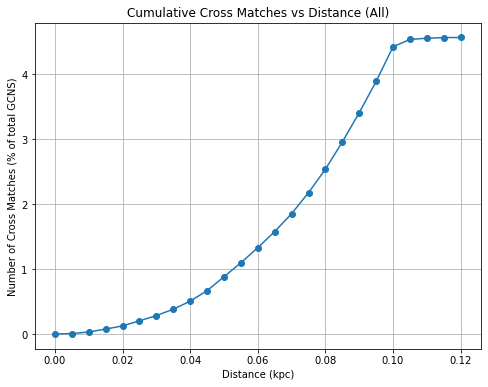

In [72]:
# === 2) Identify the catalog flag columns ===
# Example: they are named like 'is_in_HIRES', 'is_in_NEID', etc.
catalog_flags = [col for col in catalog_summary.columns if col.startswith('is_in_')]

print("Catalog flag columns:", catalog_flags)

# === 3) Make a new column: does each row have any match? ===
catalog_summary['any_match'] = catalog_summary[catalog_flags].any(axis=1).astype(int)

# === 4) Define distance bins (in kpc) ===
bins = np.arange(0, catalog_summary['Dist50'].max() + 0.005, 0.005)

# === 5) For each bin, compute % of total GCNS with a match ===
percent_matches = []
for b in bins:
    within = catalog_summary[catalog_summary['Dist50'] <= b]
    if len(within) > 0:
        percent = within['any_match'].sum() / len(catalog_summary) * 100
    else:
        percent = 0
    percent_matches.append(percent)

# === 6) Plot ===
plt.figure(figsize=(8, 6))
plt.plot(bins, percent_matches, marker='o')
plt.xlabel('Distance (kpc)')
plt.ylabel('Number of Cross Matches (% of total GCNS)')
plt.title('Cumulative Cross Matches vs Distance (All)')
plt.grid(True)
plt.show()

In [73]:
catalog_summary['Dist50'].max()

0.11931

Catalog flag columns: ['is_in_GaiaESO', 'is_in_NEID', 'is_in_HIRES', 'is_in_KPF', 'is_in_HARPS', 'is_in_APOGEE', 'is_in_CARMENES', 'is_in_GALAH', 'is_in_HST']


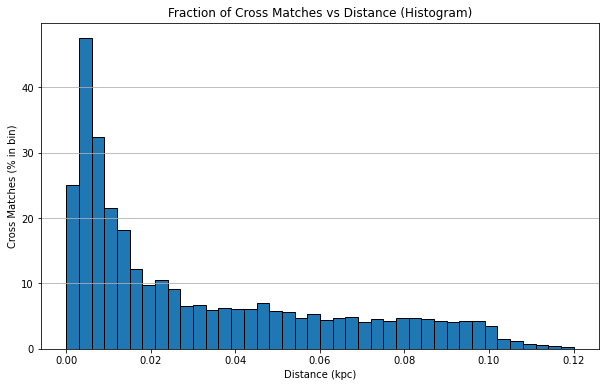

In [74]:
# === 2) Identify catalog flag columns ===
catalog_flags = [col for col in catalog_summary.columns if col.startswith('is_in_')]

print("Catalog flag columns:", catalog_flags)

# === 3) Create 'any_match': 1 if any catalog has a match ===
catalog_summary['any_match'] = catalog_summary[catalog_flags].any(axis=1).astype(int)

# === 4) Define fine bins (adjust bin width as desired) ===
bin_width = 0.003  # kpc
bins = np.arange(0, catalog_summary['Dist50'].max() + bin_width, bin_width)

# === 5) Compute % within each bin ===
fraction_per_bin = []

for i in range(len(bins) - 1):
    lower = bins[i]
    upper = bins[i + 1]
    in_bin = catalog_summary[
        (catalog_summary['Dist50'] > lower) & (catalog_summary['Dist50'] <= upper)
    ]
    if len(in_bin) > 0:
        fraction = in_bin['any_match'].sum() / len(in_bin) * 100
    else:
        fraction = 0
    fraction_per_bin.append(fraction)

# === 6) Plot as histogram ===
# Use left edges and bin width to make bars align properly
bin_lefts = bins[:-1]

plt.figure(figsize=(10, 6))
plt.bar(bin_lefts, fraction_per_bin, width=bin_width, align='edge', edgecolor='black')

plt.xlabel('Distance (kpc)')
plt.ylabel('Cross Matches (% in bin)')
plt.title('Fraction of Cross Matches vs Distance (Histogram)')
plt.grid(axis='y')
plt.show()

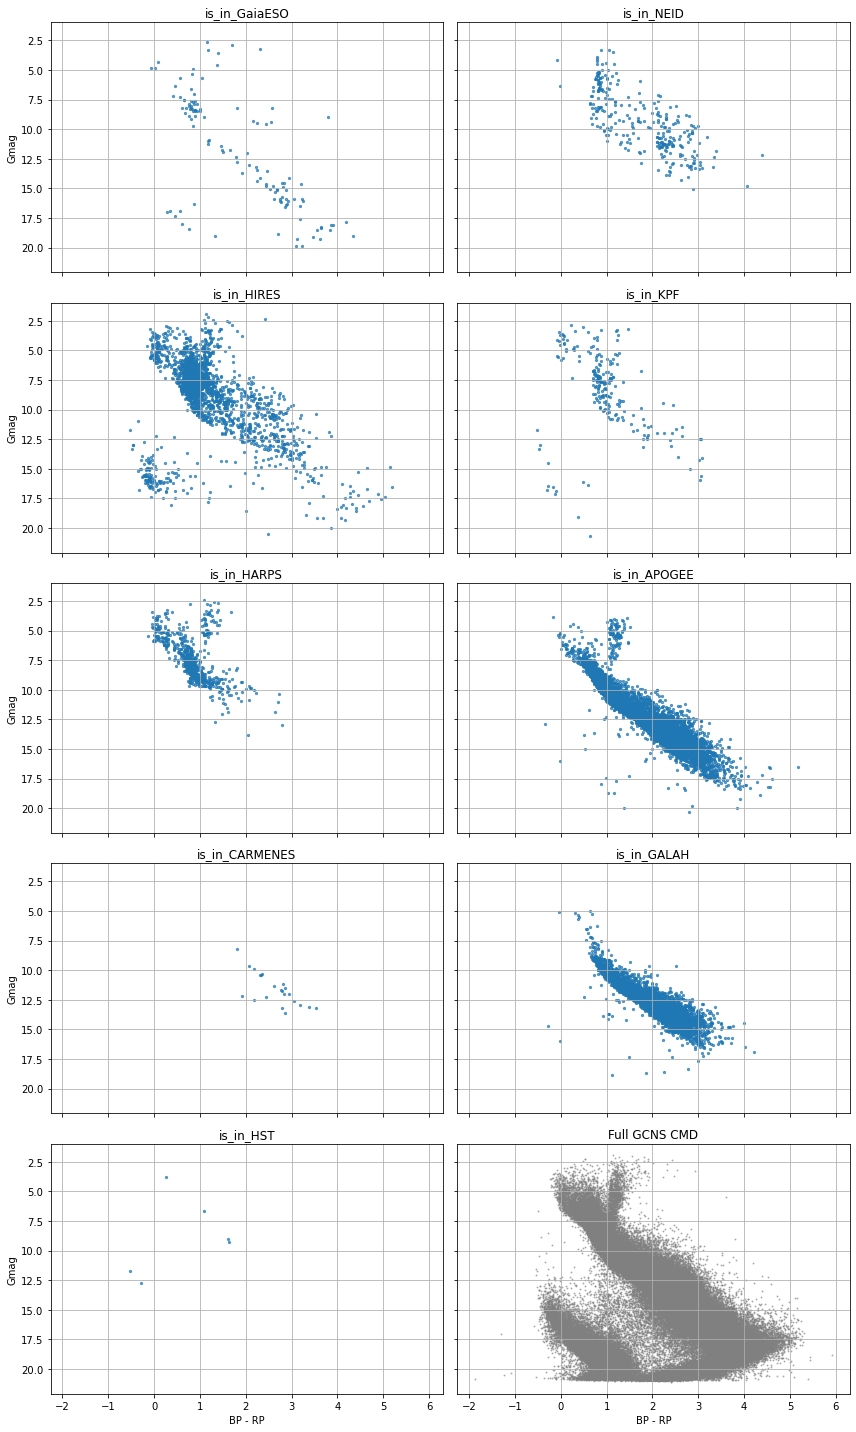

In [76]:
# === 2) Identify catalog flag columns ===
catalog_flags = [col for col in catalog_summary.columns if col.startswith('is_in_')]

# === 3) Compute Gaia color ===
catalog_summary['BP_RP'] = catalog_summary['BPmag'] - catalog_summary['RPmag']

# === 4) Setup grid ===
n_catalogs = len(catalog_flags)
n_cols = 2  # or 3 if you like
n_plots = n_catalogs + 1  # +1 for GCNS
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

# === 5) Plot each catalog CMD ===
for i, flag in enumerate(catalog_flags):
    ax = axes[i]
    subset = catalog_summary[catalog_summary[flag] == 1]
    ax.scatter(subset['BP_RP'], subset['Gmag'], s=5, alpha=0.7)
    ax.set_title(f'{flag}', fontsize=12)
    ax.invert_yaxis()
    ax.grid(True)
    if i % n_cols == 0:
        ax.set_ylabel('Gmag')
    if i // n_cols == n_rows - 1:
        ax.set_xlabel('BP - RP')

# === 6) Plot the full GCNS in the last slot ===
ax = axes[n_catalogs]  # Next available slot
ax.scatter(catalog_summary['BP_RP'], catalog_summary['Gmag'],
           s=1, color='gray', alpha=0.5)
ax.set_title('Full GCNS CMD', fontsize=12)
ax.invert_yaxis()
ax.grid(True)
if n_catalogs % n_cols == 0:
    ax.set_ylabel('Gmag')
if n_catalogs // n_cols == n_rows - 1:
    ax.set_xlabel('BP - RP')

# === 7) Hide any truly leftover empty slots (shouldn't be needed now) ===
for j in range(n_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.gca().invert_yaxis()


plt.show()


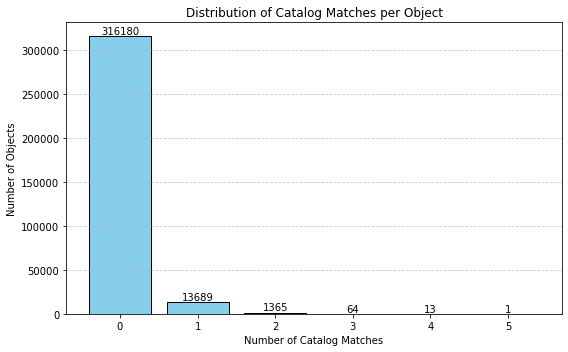

In [78]:
# === 1) Identify all columns that start with 'is_in' ===
is_in_columns = [col for col in catalog_summary.columns if col.startswith('is_in')]

# === 2) Sum across those columns row-wise to count overlaps ===
catalog_summary['num_catalog_matches'] = catalog_summary[is_in_columns].sum(axis=1)

# === Count number of objects for each number of matches ===
match_counts = catalog_summary['num_catalog_matches'].value_counts().sort_index()

# === Plot ===
plt.figure(figsize=(8, 5))
bars = plt.bar(match_counts.index, match_counts.values, color='skyblue', edgecolor='black')

# === Add labels on top of each bar ===
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,  # Adjust upward spacing as needed
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# === Customize plot ===
plt.xlabel('Number of Catalog Matches')
plt.ylabel('Number of Objects')
plt.title('Distribution of Catalog Matches per Object')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
